In [1]:
from fits_dataclass import Image, ImageSet, Transform
import numpy as np
import matplotlib.pyplot as plt
import os
from copy import copy, deepcopy
import image_utils as imutils

In [2]:
#Reload when things are added to util file
import imp
imp.reload(imutils)

<module 'image_utils' from '/Users/ryleighfitzpatrick/TitanMethane/pipeline/image_utils.py'>

In [3]:
### User inputs to go in a YAML file ###
in_dir = '/Users/ryleighfitzpatrick/TitanMethane/KeckII_Nirspec/raw_data/20170710/'

# Read in all data (science and calibration spectra)
from itertools import chain
specs = chain([in_dir+'sci/spec/'+im for im in os.listdir(in_dir+'sci/spec/')], 
              [in_dir+'cal/spec/'+im for im in os.listdir(in_dir+'cal/spec/')])
data = ImageSet([Image.load(im) for im in specs])

# Read in scam images (science)
scams = ImageSet([Image.load(in_dir+'sci/scam/'+im) for im in os.listdir(in_dir+'sci/scam/')])


In [94]:
print(set([im.header['ECHLPOS'] for im in data]))

{179.7, 62.69}


In [97]:
test = data.query(IMAGETYP='flatlamp', ECHLPOS=62.69)
len(test)
print([im.header['KOAID'] for im in test])

['NS.20170710.13070.fits', 'NS.20170710.13016.fits', 'NS.20170710.12998.fits', 'NS.20170710.13033.fits', 'NS.20170710.13052.fits']


## TO DO: Add in logging

# Part 1: Basic Image Reduction

In [4]:
# Get Master Flat Images

is_flatlamp = imutils.header_key('IMAGETYP', 'flatlamp')

getFlatsTransform = Transform(transform_op=imutils.combine_flats, filter=is_flatlamp, 
                             partition_keys=['DATE-OBS','FILNAME','SLITNAME','ECHLPOS','DISPPOS'])
fdata = getFlatsTransform(data)


100%|██████████| 6/6 [00:00<00:00, 10.39it/s]


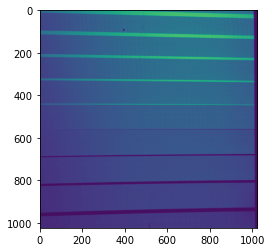

In [7]:
#Let's examine the flat field
plt.imshow([t for t in fdata if t.header['IMAGETYP']=='masterflat'][1].data)

## TO DO: Add caching abilit, especially for CR removal

In [8]:
#Cosmic Ray Clean Images
cosmicRayTransform = Transform(transform_op=imutils.cosmic_clean,partition_keys=['FILENAME'])
cr_data = cosmicRayTransform(fdata)


100%|██████████| 137/137 [13:55<00:00,  6.10s/it]


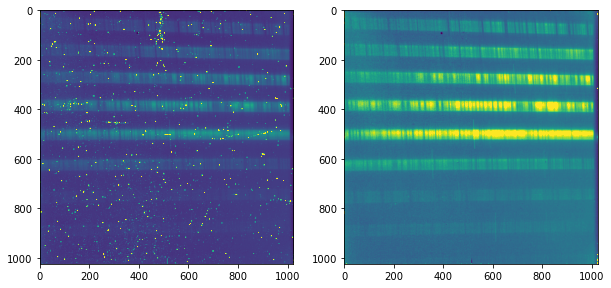

In [9]:
#Plot a cleaned and uncleaned image side by side for comparison
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(data[60].data, vmin=0, vmax=400)
cr_img = cr_data.query(FILENAME='jul10s0089.fits')
ax[1].imshow(cr_img[0].data,vmin=0,vmax=400)

## TO DO: Add in Bias, Dark and Flat Field correction!

"""# Get Master Dark Images
is_dark = imutils.header_key('IMAGETYP', 'dark')
getDarksTransform = Transform(transform_op=imutils.combine_darks, filter=is_dark,
                             partition_keys=['DATE-OBS','FILNAME','SLITNAME','ECHLPOS','DISPPOS'])
d_data = getDarksTransform(cr_data)

bias = 
print(set([im.header['ITIME'] for im in d_data.query(IMAGETYP = 'flatlampoff')]))
print(set([im.header['ITIME'] for im in d_data.query(IMAGETYP = 'object')]))
print(set([im.header['ITIME'] for im in d_data.query(IMAGETYP = 'masterdark')]))

#### Subtract Dark from Object and Flat Images
subDarksTransform = Transform(transform_op=perform_darksub,
                             partition_keys=['ITIME'])
dsub_data = subDarksTransform(d_data)"""




## TO DO (?): Add in handeling for nod pairs (only relevant for 2015) 

In [22]:
from scipy.signal import argrelextrema
    
def find_peaks(edge_profile):

        peak_rows = argrelextrema(edge_profile, np.greater, order=35)[0]
        peak_intensities = edge_profile[peak_rows]
        tall_peaks_i = np.where(
            peak_intensities > (
                np.amax(peak_intensities) * 0.10))

        return(peak_rows[tall_peaks_i[0]])

def find_flat_edges(flat):

        # make top and bottom edge profile images
        rolled = np.roll(flat.data, 5, axis=0)
        top_edge = rolled - flat.data
        bot_edge = flat.data - rolled

        top_profile = np.median(top_edge[:, 40:50], axis=1)
        bot_profile = np.median(bot_edge[:, 40:50], axis=1)

        top_peaks = find_peaks(top_profile)
        bot_peaks = find_peaks(bot_profile)

        return bot_peaks, top_peaks

In [35]:
flat = cr_data.query(IMAGETYP = 'masterflat')[1]

In [36]:
bot_peaks, top_peaks = find_flat_edges(flat)

# plt.imshow(np.roll(test_flat.data, 5, axis=0), origin='lower')
# for peak in bot_peaks:
#     plt.axhline(y = peak, color='r') 
# for peak in top_peaks:
#     plt.axhline(y = peak, color='cyan') 


In [40]:
import grating_eq
nOrdersExpected = 0
firstOrderFound = False

# expected order number at bottom of detector
starting_order = {
    'NIRSPEC-1': 80,
    'NIRSPEC-2': 70,
    'NIRSPEC-3': 67,
    'NIRSPEC-4': 61,
    'NIRSPEC-5': 53,
    'NIRSPEC-6': 49,
    'NIRSPEC-7': 41
}

filtername = flat.header['FILNAME']

for order_num in range(starting_order[flat.header['FILNAME'][:9]], 0, -1):
    top_calc, bot_calc, gE_wave_scale = grating_eq.evaluate(
                order_num, self.filterName, self.slit, self.echelleAngle, self.disperserAngle)

53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
